In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Project/dataset"


In [ ]:
import os

# List categories inside dataset
categories = os.listdir(dataset_path)
print("Dataset categories:", categories)


Dataset categories: ['Normal', 'Polyp', 'Low-grade IN', 'High-grade IN', 'Adenocarcinoma', 'Serrated adenoma']


In [ ]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")


Normal: 76 images
Polyp: 474 images
Low-grade IN: 639 images
High-grade IN: 186 images
Adenocarcinoma: 795 images
Serrated adenoma: 58 images


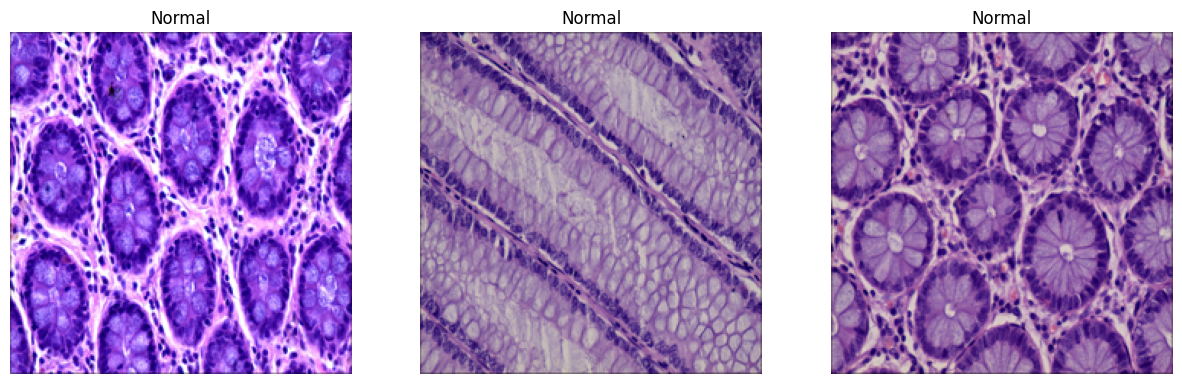

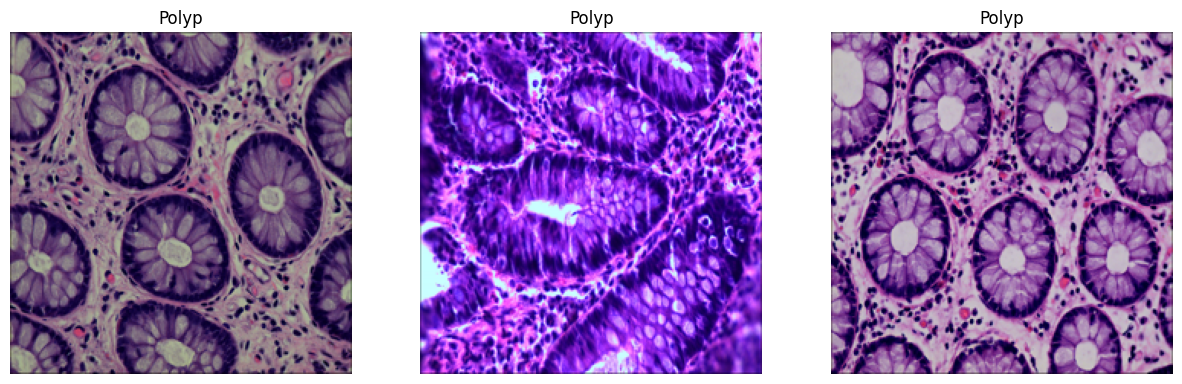

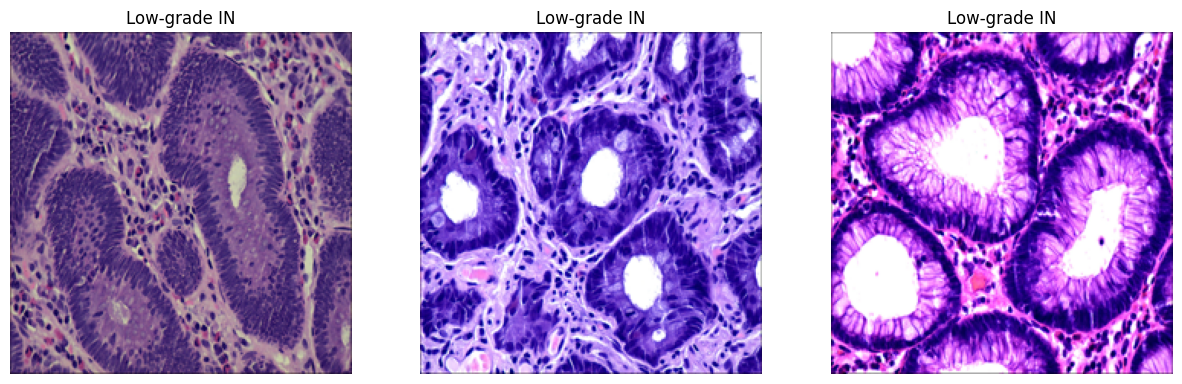

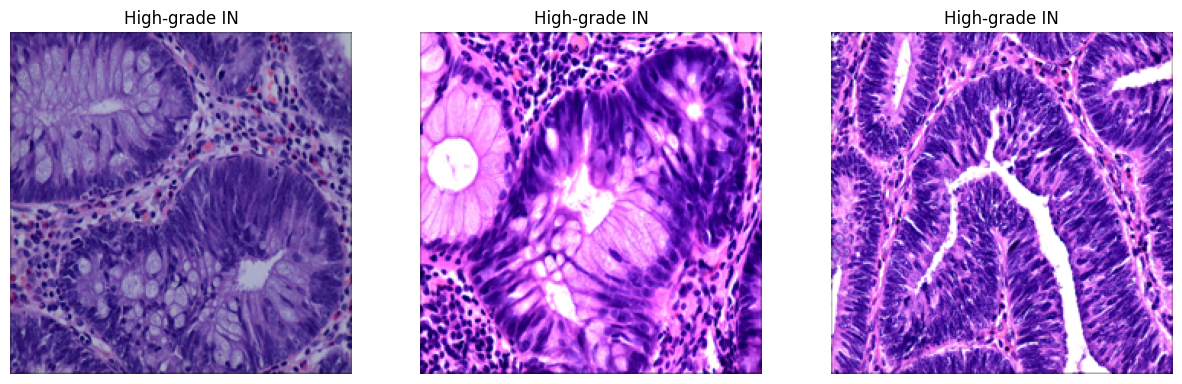

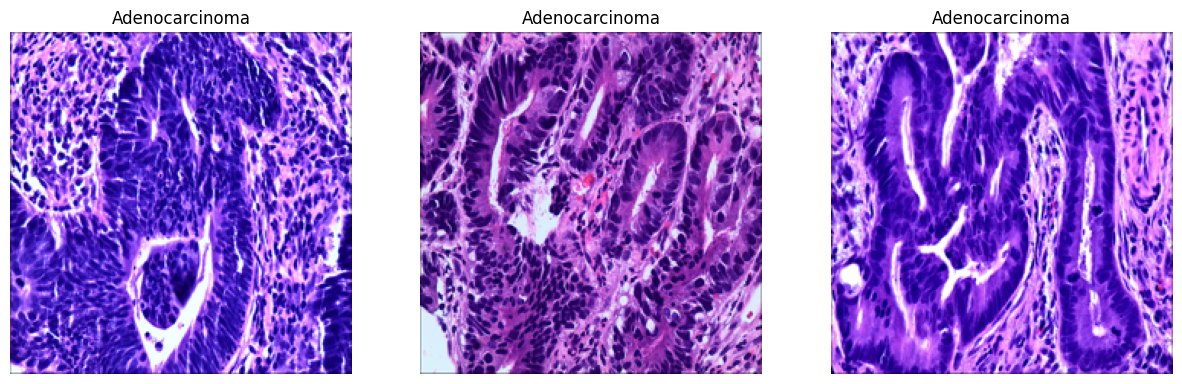

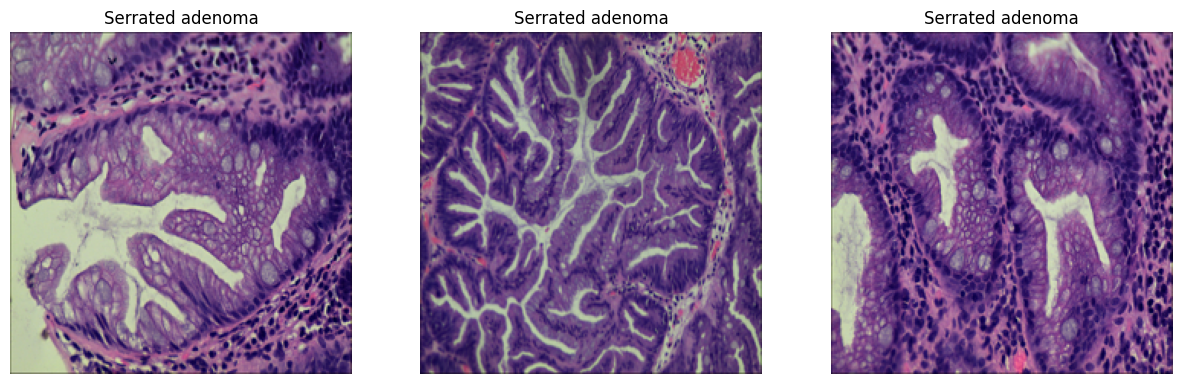

In [ ]:

import matplotlib.pyplot as plt
import cv2
import random

# Function to show sample images
def show_sample_images(category, num_images=5):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    sample_images = random.sample(images, min(num_images, len(images)))

    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for ax, img_name in zip(axes, sample_images):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(category)

    plt.show()

# Display sample images from each category
for category in categories:
    show_sample_images(category, num_images=3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Parameters
batch_size = 32
img_size = (224, 224)  # Adjust this based on your model requirements
validation_split = 0.2  # 20% of the data for validation

# Initialize ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Apply random shearing
    zoom_range=0.2,  # Apply random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=validation_split,  # Split dataset
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=validation_split,  # Split dataset
)

In [ ]:
# Load training dataset
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Use "categorical" for multi-class classification
    subset="training",
    seed=123,  # Seed for reproducibility
)

# Load validation dataset
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Use "categorical" for multi-class classification
    subset="validation",
    seed=123,  # Ensure consistent splitting
)

Found 1785 images belonging to 6 classes.
Found 443 images belonging to 6 classes.


In [ ]:
# Print class indices
print("Class indices:", train_generator.class_indices)

# Example: Check a batch of images and labels
images, labels = next(train_generator)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Class indices: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4, 'Serrated adenoma': 5}
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 6)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input, applications
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

# Parameters
input_shape = (224, 224, 3)  # Input image dimensions
n_out = 6  # Number of output classes

def create_model(input_shape, n_out):
    # Define the input tensor
    input_tensor = Input(shape=input_shape)

    # Load EfficientNetB0 as the base model
    base_model = applications.EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_tensor=input_tensor
    )

    # Add classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  # Regularization with dropout
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation="softmax", name="final_output")(x)  # Softmax for multi-class classification
    model = Model(input_tensor, final_output)

    return model

# Create the model
model = create_model(input_shape=input_shape, n_out=n_out)

# Freeze all layers in the base model
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 5 layers of the base model for fine-tuning
for layer in model.layers[-5:]:
    layer.trainable = True

# Compile the model
metric_list = ["accuracy"]  # Metrics for monitoring
LEARNING_RATE = 5e-5  # Set an appropriate learning rate
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)  # Multi-class loss

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,367,465 (20.48 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Finetune the complete model
for layer in model.layers:
    layer.trainable = True

# es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

# callback_list = [es, rlrop]
callback_list = [rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,367,465 (20.48 MB)

 Trainable params: 5,325,442 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
try:
    # Fit the model using the data generators
    history_finetuning = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=25,
        callbacks=callback_list,
        verbose=1
    ).history
except Exception as e:
    print("An error occurred during training:", e)


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3540 - loss: 1.6102 - val_accuracy: 0.0248 - val_loss: 1.9741 - learning_rate: 5.0000e-05
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 626ms/step - accuracy: 0.6598 - loss: 1.0524 - val_accuracy: 0.0248 - val_loss: 1.8924 - learning_rate: 5.0000e-05
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 618ms/step - accuracy: 0.7587 - loss: 0.7488 - val_accuracy: 0.0406 - val_loss: 1.8500 - learning_rate: 5.0000e-05
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 648ms/step - accuracy: 0.7629 - loss: 0.6541 - val_accuracy: 0.2257 - val_loss: 1.7990 - learning_rate: 5.0000e-05
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 618ms/step - accuracy: 0.8213 - loss: 0.5069 - val_accuracy: 0.1084 - val_loss: 1.9483 - learning_rate: 5.0000e-05
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 593ms/step - accuracy: 0.8168 - loss: 0.4896 - val_accuracy: 0.0384 - val_loss: 2.0998 - learning_rate: 5.0000e-05
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 621ms/step - accur

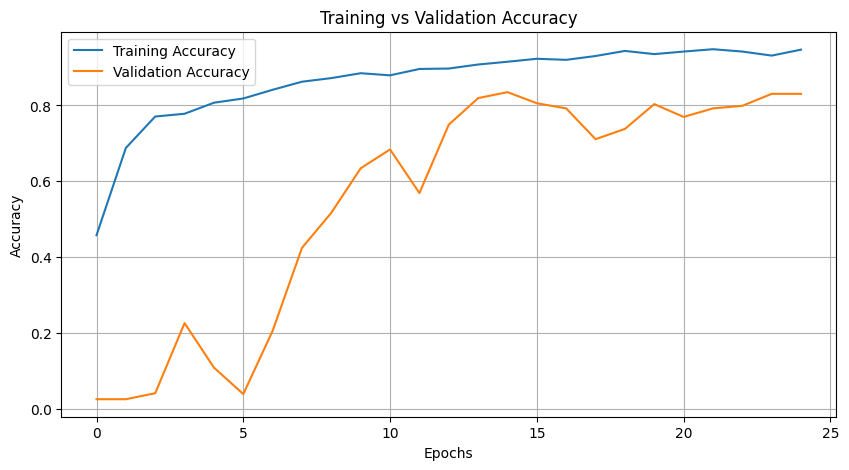

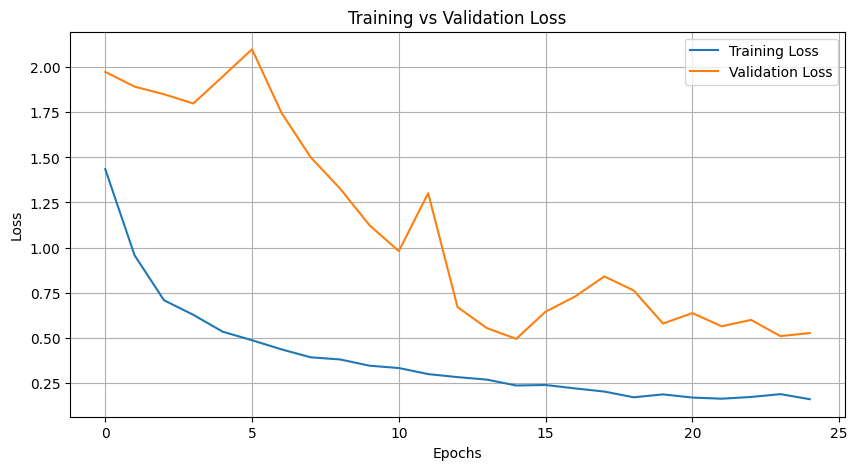

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_finetuning['accuracy'], label='Training Accuracy')
plt.plot(history_finetuning['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_finetuning['loss'], label='Training Loss')
plt.plot(history_finetuning['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.8242 - loss: 0.5811
Validation Accuracy: 83.07%


In [ ]:
# Create an ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values

# Load test dataset
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 2228 images belonging to 6 classes.


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.9295 - loss: 0.2005
Test Accuracy: 92.82%
Test Loss: 0.2105


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
true_labels = test_generator.classes  # True class labels

# Get class names
class_names = list(test_generator.class_indices.keys())

# Predict classes
predictions = model.predict(test_generator)  # Probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Convert to class labels



70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step


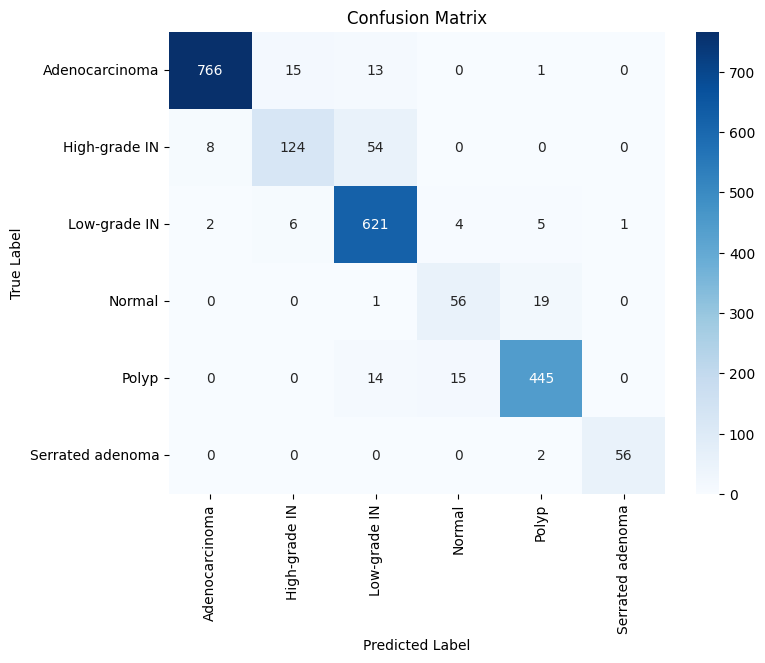

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_classes, target_names=class_names))


Classification Report:
                   precision    recall  f1-score   support

  Adenocarcinoma       0.99      0.96      0.98       795
   High-grade IN       0.86      0.67      0.75       186
    Low-grade IN       0.88      0.97      0.93       639
          Normal       0.75      0.74      0.74        76
           Polyp       0.94      0.94      0.94       474
Serrated adenoma       0.98      0.97      0.97        58

        accuracy                           0.93      2228
       macro avg       0.90      0.87      0.88      2228
    weighted avg       0.93      0.93      0.93      2228



In [ ]:
# Save in the new Keras format
model.save("colorectal_cancer_model.keras")
